In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import re



In [2]:
#df = pd.read_csv('../input/train.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Fill missing fields with columns means
df = df.fillna(df.mean())
df['Cabin'] = df['Cabin'].fillna('U')
df = df.fillna('N/A')

# Fill missing fields with columns means
df_test = df_test.fillna(df_test.mean())
df_test['Cabin'] = df_test['Cabin'].fillna('U')
df_test = df_test.fillna('N/A')

print(df.head())
print(df_test.head())

print(df.describe())
print(df.dtypes)


# Transforming cabin code to a deck, adding 'U' (unknown) for the missing ones
df['Deck'] = pd.Series([re.split('(\d.*)',s)[0][0] for s in df['Cabin']])
df_test['Deck'] = pd.Series([re.split('(\d.*)',s)[0][0] for s in df_test['Cabin']])

#print(df['Deck'])
print(df['Deck'].unique())
print(df_test['Deck'].unique())



   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500     U        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250     U        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500     U        S  
  

# Labeling

In [3]:
labels = ['Sex', 'Embarked', 'Deck']
les = {}

for l in labels:
    print('labeling ' + l)
    les[l] = LabelEncoder()
    les[l].fit(df[l])
    tr = les[l].transform(df[l]) 
    df.loc[:, l + '_feat'] = pd.Series(tr, index=df.index)

    tr_test = les[l].transform(df_test[l]) 
    df_test.loc[:, l + '_feat'] = pd.Series(tr_test, index=df_test.index)


# le.classes_
print(df.head())

labeling Sex
labeling Embarked
labeling Deck
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Deck  Sex_feat  \
0      0         A/5 21171   7.2500     U        S    U         1   
1      0          PC 17599  71.2833   C85        C    C         0   
2      0  STON/O2. 3101282   7.9250     U        S    U         0   

# Preparing datasets

In [6]:
X_train = df.drop(labels, 1) \
    .drop('Survived', 1) \
    .drop('Cabin', 1) \
    .drop('Ticket', 1) \
    .drop('Name', 1) \
    .drop('PassengerId', 1)
y_train = df['Survived']

X_test = df_test.drop(labels, 1) \
    .drop('Cabin', 1) \
    .drop('Ticket', 1) \
    .drop('Name', 1) \
    .drop('PassengerId', 1)

print("training set head", X_train.head())
print("training set result shape", y_train.shape)
print("test set head", X_test.head())
print("test set head", X_test.shape)


training set head    Pclass   Age  SibSp  Parch     Fare  Sex_feat  Embarked_feat  Deck_feat
0       3  22.0      1      0   7.2500         1              3          8
1       1  38.0      1      0  71.2833         0              0          2
2       3  26.0      0      0   7.9250         0              3          8
3       1  35.0      1      0  53.1000         0              3          2
4       3  35.0      0      0   8.0500         1              3          8
training set result shape (891,)
test set head    Pclass   Age  SibSp  Parch     Fare  Sex_feat  Embarked_feat  Deck_feat
0       3  34.5      0      0   7.8292         1              2          8
1       3  47.0      1      0   7.0000         0              3          8
2       2  62.0      0      0   9.6875         1              2          8
3       3  27.0      0      0   8.6625         1              3          8
4       3  22.0      1      1  12.2875         0              3          8
test set head (418, 8)


# Training some models

## Linear regression

Trained for C =  0.7 with score  0.786756453423
Trained for C =  0.9 with score  0.786756453423
Trained for C =  1.1 with score  0.786756453423
Trained for C =  1.3 with score  0.786756453423
Trained for C =  1.5 with score  0.786756453423


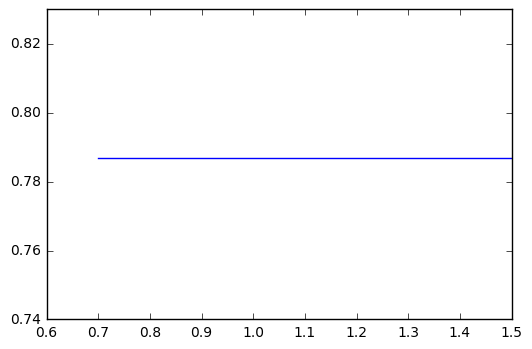

In [8]:
cs = np.arange(0.7, 1.7, 0.2)
results = []
for C in cs:
    svc_linear = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
    score = svc_linear.score(X_train, y_train)
    results.append(score)
    print("Trained for C = ", C, "with score ", score )

plt.plot(cs, results)

In [9]:

C = 1.0  # SVM regularization parameter
svc_linear = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)

print(svc_linear.score(X_train, y_train)) # 0.78675645342312006 before including the Deck


0.786756453423


# Testing on the test set

In [10]:
pred = svc_linear.predict(X_test)
print(pred.shape)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]
print(sub.head())
print(sub.tail())

sub.to_csv('submission_linear.csv', index=False)


(418,)
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
     PassengerId  Survived
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0


0.920314253648
(418,)
   PassengerId  Survived
0          892         0
1          893         0
2          894         1
3          895         0
4          896         0
     PassengerId  Survived
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0


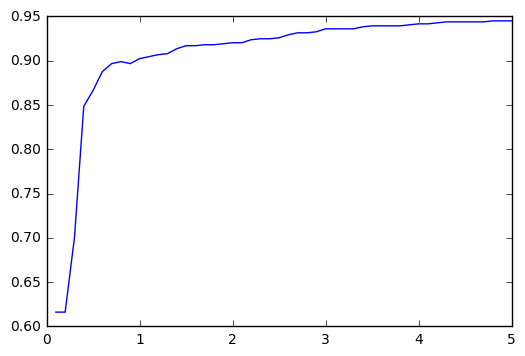

In [11]:
cs = np.arange(0.1, 5.1, 0.1)
results = []
for C in cs:
    svc_rbf = svm.SVC(kernel='rbf', C=C).fit(X_train, y_train)
    results.append(svc_rbf.score(X_train, y_train))

C = 2.0  # SVM regularization parameter
svc_rbf = svm.SVC(kernel='rbf', C=C).fit(X_train, y_train)

print(svc_rbf.score(X_train, y_train)) 

plt.plot(cs, results)
    
pred = svc_rbf.predict(X_test)
print(pred.shape)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]
print(sub.head())
print(sub.tail())


sub.to_csv('submission_rbf.csv', index=False)


In [20]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [21]:
forest.score(X_train, y_train)

0.88888888888888884

In [22]:
pred = forest.predict(X_test)
print(pred.shape)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]
print(sub.head())
print(sub.tail())


sub.to_csv('submission_forest.csv', index=False)


(418,)
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         1
4          896         0
     PassengerId  Survived
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0


In [15]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
lr.score(X_train, y_train)

0.80022446689113358

In [17]:
pred = lr.predict(X_test)
print(pred.shape)

df_test['Survived'] = pd.Series(pred)
sub = df_test[['PassengerId','Survived']]
print(sub.head())
print(sub.tail())


sub.to_csv('submission_lr.csv', index=False)


(418,)
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
     PassengerId  Survived
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0
